In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
faces_zip = "/content/drive/MyDrive/Face.zip"
nonfaces_zip = "/content/drive/MyDrive/Nonhuman_objects.zip"

!mkdir -p /content/dataset/face
!mkdir -p /content/dataset/nonface

!unzip -qo $faces_zip -d /content/dataset/face
!unzip -qo $nonfaces_zip -d /content/dataset/nonface


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


In [4]:
import os, shutil
import numpy as np

In [5]:
def split_dataset(src_dir, dst_root, class_name, split=(0.7,0.2,0.1)):
    files = os.listdir(src_dir)
    np.random.shuffle(files)

    n_total = len(files)
    n_train = int(split[0] * n_total)
    n_val = int(split[1] * n_total)

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for subdir in ["train", "val", "test"]:
        os.makedirs(os.path.join(dst_root, subdir, class_name), exist_ok=True)

    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "train", class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "val", class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "test", class_name, f))


In [6]:
split_dataset("/content/dataset/face", "/content/dataset_ready", "face")
split_dataset("/content/dataset/nonface", "/content/dataset_ready", "nonface")


In [7]:
import os
from PIL import Image

data_dir = "/content/dataset_ready"
max_size = (1280, 1280)

def resize_big_images(data_dir, max_size=(1280,1280)):
    for root, dirs, files in os.walk(data_dir):
        for f in files:
            path = os.path.join(root, f)
            try:
                img = Image.open(path)
                if img.size[0] * img.size[1] > 8947848:
                    print(f"Resizing {path} from {img.size}...")
                    img.thumbnail(max_size, Image.Resampling.LANCZOS)
                    img.save(path)
            except Exception as e:
                print(f"Ошибка с {path}: {e}")

resize_big_images(data_dir, max_size=(1280,1280))


Resizing /content/dataset_ready/test/face/irene-strong--FOUPtqP-mY-unsplash(1).jpg from (4928, 3264)...
Resizing /content/dataset_ready/test/face/stefan-stefancik-QXevDflbl8A-unsplash.jpg from (4912, 7360)...
Resizing /content/dataset_ready/test/face/alex-zeng-SPE-PolG3ZI-unsplash.jpg from (3024, 4032)...
Resizing /content/dataset_ready/test/face/dian-yu-f18mZ_kI4Mk-unsplash.jpg from (6168, 9252)...
Resizing /content/dataset_ready/test/face/setengah-limasore-fFN6WlyaAY0-unsplash.jpg from (3376, 6000)...
Resizing /content/dataset_ready/test/face/setengah-limasore-T1qroWVyojU-unsplash.jpg from (3376, 6000)...
Resizing /content/dataset_ready/test/face/max-ovcharenko-ab3NfsI3pIY-unsplash.jpg from (4000, 6000)...
Resizing /content/dataset_ready/test/face/nurlan-imash-Adm6ppwXCso-unsplash.jpg from (4000, 5482)...
Resizing /content/dataset_ready/test/face/joseph-gonzalez-iFgRcqHznqg-unsplash.jpg from (3569, 5354)...
Resizing /content/dataset_ready/test/face/setengah-limasore-flOgb-ayy2Y-unspl

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (119997141 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Resizing /content/dataset_ready/train/face/ospan-ali-ivIq7icbnnM-unsplash.jpg from (8949, 13409)...
Resizing /content/dataset_ready/train/face/mathew-schwartz-WpNfKGZDZEw-unsplash.jpg from (3252, 3252)...
Resizing /content/dataset_ready/train/face/cesar-rincon-XHVpWcr5grQ-unsplash.jpg from (3220, 3220)...
Resizing /content/dataset_ready/train/face/setengah-limasore-Pcc5wTKCCr0-unsplash.jpg from (3376, 6000)...
Resizing /content/dataset_ready/train/face/fadhil-abhimantra-WLggWHtSnjA-unsplash.jpg from (6192, 7740)...
Resizing /content/dataset_ready/train/face/imansyah-muhamad-putera-n4KewLKFOZw-unsplash.jpg from (3456, 3456)...
Resizing /content/dataset_ready/train/face/ben-o-bro-C5XyLljkMrY-unsplash.jpg from (3648, 5472)...
Resizing /content/dataset_ready/train/face/fadhil-abhimantra-x4ldh59QJ1s-unsplash.jpg from (5650, 7063)...
Resizing /content/dataset_ready/train/face/lesha-tuman-CC4I9qKCR0o-unsplash.jpg from (3782, 4266)...
Resizing /content/dataset_ready/train/face/amir-mohammad-hp

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Пути к папкам
data_dir = "/content/dataset_ready"
train_face_dir = os.path.join(data_dir, "train", "face")
train_nonface_dir = os.path.join(data_dir, "train", "nonface")
val_face_dir = os.path.join(data_dir, "val", "face")
val_nonface_dir = os.path.join(data_dir, "val", "nonface")
test_face_dir = os.path.join(data_dir, "test", "face")
test_nonface_dir = os.path.join(data_dir, "test", "nonface")

# Размер картинок для приведения
IMG_SIZE = 1280

# Функция загрузки изображений
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # черно-белое
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img.flatten())  # делаем вектор
            labels.append(label)
    return images, labels

print("[INFO] Загружаем данные...")
X_train_face, y_train_face = load_images_from_folder(train_face_dir, 1)
X_train_nonface, y_train_nonface = load_images_from_folder(train_nonface_dir, 0)
X_val_face, y_val_face = load_images_from_folder(val_face_dir, 1)
X_val_nonface, y_val_nonface = load_images_from_folder(val_nonface_dir, 0)
X_test_face, y_test_face = load_images_from_folder(test_face_dir, 1)
X_test_nonface, y_test_nonface = load_images_from_folder(test_nonface_dir, 0)

X_train = np.array(X_train_face + X_train_nonface)
y_train = np.array(y_train_face + y_train_nonface)
X_val = np.array(X_val_face + X_val_nonface)
y_val = np.array(y_val_face + y_val_nonface)
X_test = np.array(X_test_face + X_test_nonface)
y_test = np.array(y_test_face + y_test_nonface)

print("[INFO] Размеры:")
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

[INFO] Загружаем данные...
[INFO] Размеры:
Train: (207, 1638400) (207,)
Val: (59, 1638400) (59,)
Test: (31, 1638400) (31,)


[INFO] Обучаем KNN...
[INFO] Делаем предсказания на тесте...
[RESULT] Accuracy модели (Test): 0.5806
[INFO] Строим confusion matrix...


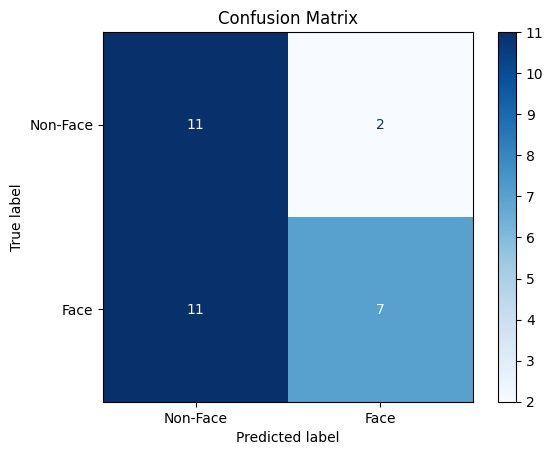

In [12]:
print("[INFO] Обучаем KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print("[INFO] Делаем предсказания на тесте...")
y_pred = knn.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"[RESULT] Accuracy модели (Test): {acc:.4f}")

# Confusion Matrix
print("[INFO] Строим confusion matrix...")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Face", "Face"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

[INFO] Тестируем разные значения k на validation...
k=1, accuracy (val)=0.5932
k=2, accuracy (val)=0.5424
k=3, accuracy (val)=0.5254
k=4, accuracy (val)=0.5593
k=5, accuracy (val)=0.5424
k=6, accuracy (val)=0.5932
k=7, accuracy (val)=0.5932
k=8, accuracy (val)=0.4915
k=9, accuracy (val)=0.5424
k=10, accuracy (val)=0.5085
k=11, accuracy (val)=0.5254
k=12, accuracy (val)=0.5085
k=13, accuracy (val)=0.5254
k=14, accuracy (val)=0.5254
k=15, accuracy (val)=0.5254
k=16, accuracy (val)=0.4746
k=17, accuracy (val)=0.4915
k=18, accuracy (val)=0.4746
k=19, accuracy (val)=0.4915
k=20, accuracy (val)=0.5085


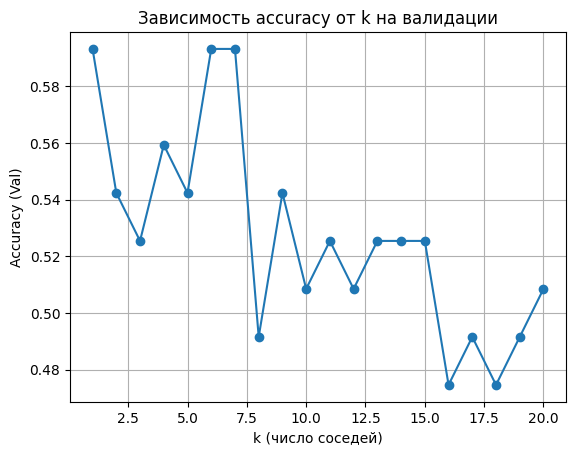

In [13]:
print("[INFO] Тестируем разные значения k на validation...")
k_values = list(range(1, 21))
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_val = knn.predict(X_val)
    acc_k = accuracy_score(y_val, y_pred_val)
    accuracies.append(acc_k)
    print(f"k={k}, accuracy (val)={acc_k:.4f}")

plt.plot(k_values, accuracies, marker='o')
plt.xlabel("k (число соседей)")
plt.ylabel("Accuracy (Val)")
plt.title("Зависимость accuracy от k на валидации")
plt.grid(True)
plt.show()


Dataset given by sklearn (fetch_olivetti_faces)

[INFO] Загружаем датасет Olivetti Faces...
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
[INFO] Размер данных: (400, 4096) (400,)
[INFO] Разделяем train/test...
[INFO] Обучаем KNN...
[RESULT] Accuracy модели (Test): 0.8250
[INFO] Строим confusion matrix...


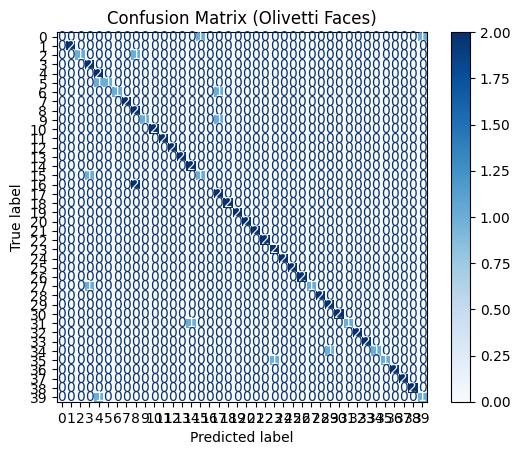

[INFO] Тестируем разные значения k...
k=1, accuracy=0.9500
k=2, accuracy=0.8875
k=3, accuracy=0.8875
k=4, accuracy=0.8750
k=5, accuracy=0.8250
k=6, accuracy=0.7750
k=7, accuracy=0.8125
k=8, accuracy=0.8375
k=9, accuracy=0.8000
k=10, accuracy=0.7875
k=11, accuracy=0.7500
k=12, accuracy=0.7125
k=13, accuracy=0.6875
k=14, accuracy=0.6625
k=15, accuracy=0.6500
k=16, accuracy=0.6500
k=17, accuracy=0.6625
k=18, accuracy=0.6375
k=19, accuracy=0.6250
k=20, accuracy=0.6375


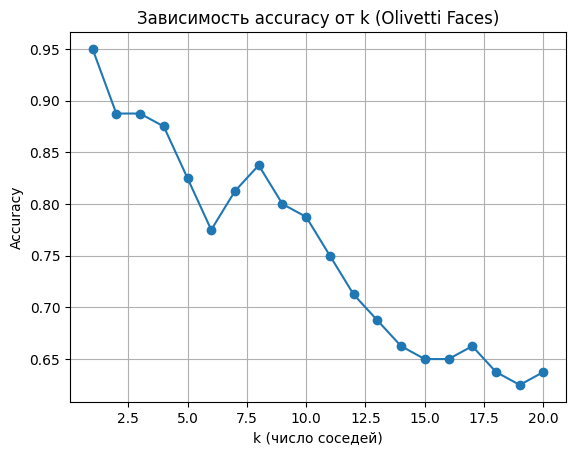

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

print("[INFO] Загружаем датасет Olivetti Faces...")
olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)
X = olivetti.data  # уже векторизованные 64x64 изображения
y = olivetti.target

print("[INFO] Размер данных:", X.shape, y.shape)

# Разделение train/test
print("[INFO] Разделяем train/test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Обучение KNN
print("[INFO] Обучаем KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Предсказания
y_pred = knn.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"[RESULT] Accuracy модели (Test): {acc:.4f}")

# Confusion Matrix
print("[INFO] Строим confusion matrix...")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix (Olivetti Faces)")
plt.show()

# Зависимость качества от k
print("[INFO] Тестируем разные значения k...")
k_values = list(range(1, 21))
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    acc_k = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc_k)
    print(f"k={k}, accuracy={acc_k:.4f}")

plt.plot(k_values, accuracies, marker='o')
plt.xlabel("k (число соседей)")
plt.ylabel("Accuracy")
plt.title("Зависимость accuracy от k (Olivetti Faces)")
plt.grid(True)
plt.show()
